# Selecting data & finding the most common complaint type

## Install

In [1]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# !pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


✅ The installed version of syft==0.8.1b2 matches the requirement >=0.8.1b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-2", port=8082, reset=True)

Starting pandas-test-domain-1 server on 0.0.0.0:8080
SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/40749bbfe1af4a208ca15e0c35be3b09.sqlite



# Data Owner: Upload data

In [4]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [5]:
from syft.serde.mock import CachedFaker
from random import randint
from syft.util.util import PANDAS_DATA
from syft.service.project.project import Project
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [7]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(sy.autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [8]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

## Create Mock data

Let's create the mock data for the complaint dataset.

In [9]:
fake = CachedFaker()

In [10]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [11]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [12]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [13]:
mock = pd.DataFrame(data=mock_data)

In [14]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,754048,1997-08-21 02:55:18,2002-07-22 03:11:56,DOHMH,Bryce Thomas,'Animal in a Park',Broken Fence,Public/Unfenced Area,47769,"47306 Allen Trail Suite 561\nEast Jeffrey, ME ...",Maria Mason,Johnson Walk,Michaela Grove,Guerrero Well,Jeremiah Passage,LATLONG,North Brett,BKLYN BATTERY TUNNEL,NaN,Open,2022-04-21 12:42:34,1999-08-26 06:00:40,17 BROOKLYN,QUEENS,760120,550110,Teresa Taylor,BROOKLYN,Adam Gray,B099,Region 5,11X175,7187712787,"34126 Joshua Land Suite 735\nCarolview, MD 24423",FRESH MEADOWS,Unspecified,19083,Y,NaN,Ambulette / Paratransit,NaN,Other,Clearview Expwy,Southbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Far Rockaway #2 Field,Manhattan Bound,Austen,-158.664733,28.120557,"(-26.290897, 118.469226)"
1,594360,1975-04-15 15:31:02,2008-10-30 19:45:32,DPR,Charles Davis,Illegal Parking,Branches Damaged,1-3 Family Dwelling,44577,"0287 Wanda Loaf Suite 061\nLake Tracy, AK 74257",Karen Gonzalez,Sparks Estates,Heather Corner,Acosta Fields,Bennett Junctions,BLOCKFACE,Timothyborough,MUSEUM NATURAL HIST,NaN,Started,2003-01-07 04:08:24,2018-10-02 17:43:58,05 QUEENS,MANHATTAN,809072,832141,Patricia Harvey,BROOKLYN,Rachel Franklin,B100,Region 1,31R440,7186672165,"319 Thomas Loaf\nSouth Amanda, KS 46995",QUEENS,NY,63175,N,NaN,NaN,STATEN ISLAND,New York-Penn Station,Belt Pkwy,South/Queens Bound,Roadway,Grand Central Pkwy (Exit 1 E-W),White Plains Road Field,Staten Island Bound,MITCHELL HOUSES SENIOR CENTER,-37.588287,149.264869,"(169.839201, 39.387419)"
2,541103,1976-02-01 20:49:11,1975-06-13 18:48:48,NYPD,Rachel Rivera,'Animal in a Park',Broken Fence,Service Provider,18669,"233 Keith Underpass Apt. 864\nRodriguezport, A...",Joseph Stout,Steven Valleys,Michaela Grove,Black Falls,Lauren Brook,NaN,New Julie,WORLDS FAIR MARINA,Precinct,Closed,2006-06-18 20:48:44,1970-01-25 00:06:32,16 BROOKLYN,BROOKLYN,460035,694043,Tammy Vaughn,BRONX,Jonathan Mcdowell,B099,Unspecified,31R011,7188224282,"549 Miranda Plaza\nNorth Meganmouth, VT 20018",REGO PARK,NY,77128,Y,NaN,NaN,BROOKLYN,Grand Central Station,Eastern Blvd Br - Edgewater Rd,East/Long Island Bound,NaN,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Sheepshead Bay #1 Field,Staten Island Bound,FRANCISCA URBANO,100.186502,134.979995,"(-135.915409, 119.788845)"
3,111653,1975-06-13 18:48:48,2015-07-16 07:28:04,NYPD,Stuart Young,'Animal in a Park',Broken Glass,3+ Family Apt. Building,38164,"0681 Joel Summit\nCooperport, MI 91918",Maria Mason,Turner Locks,Andrew Viaduct,Andrew Viaduct,Deborah Village,ADDRESS,North Gina,UNION SQUARE PARK,Precinct,Assigned,1995-03-04 22:50:57,2017-08-29 21:24:34,07 BRONX,BRONX,878566,341691,Sherry Bell,Unspecified,Jacob Mayer,B079,Region 9,22K139,7188605544,"83819 Owens Forges\nEast Derekside, TX 92248",EAST ELMHURST,Unspecified,44577,Y,NaN,Ambulette / Paratransit,MANHATTAN,NaN,Bruckner Expwy,North/Bronx Bound,Ramp,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Broome and Ludlow Field,Manhattan Bound,St. George Terminal (Staten Island),-60.974047,-157.146979,"(118.469226, -135.915409)"
4,129588,2018-12-29 11:45:51,1972-02-16 23:10:57,DPR,Christopher Fletcher,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Other (explain in Complaint Details),98422,"917 Lang

In [15]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)

  0%|                                                                                                                 | 0/1 [00:00<?, ?it/s]

Uploading: complaints


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.24s/it]


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## Create data scientist

In [16]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: create syft_function

## Download mock and submit project

### Get mock

In [17]:
guest_domain_client = node.client

In [18]:
# guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [19]:
ds = guest_domain_client.datasets[0]

In [20]:
asset = ds.assets["complaints"]

In [21]:
complaints = asset.mock

### What's even in it? (the summary)


When you print a large dataframe, it will only show you the first few rows.

If you don't see this, don't panic! The default behavior for large dataframes changed between pandas 0.12 and 0.13. Previous to 0.13 it would show you a summary of the dataframe. This includes all the columns, and how many non-null values there are in each column.

In [22]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,754048,1997-08-21 02:55:18,2002-07-22 03:11:56,DOHMH,Bryce Thomas,'Animal in a Park',Broken Fence,Public/Unfenced Area,47769,"47306 Allen Trail Suite 561\nEast Jeffrey, ME ...",Maria Mason,Johnson Walk,Michaela Grove,Guerrero Well,Jeremiah Passage,LATLONG,North Brett,BKLYN BATTERY TUNNEL,None,Open,2022-04-21 12:42:34,1999-08-26 06:00:40,17 BROOKLYN,QUEENS,760120,550110,Teresa Taylor,BROOKLYN,Adam Gray,B099,Region 5,11X175,7187712787,"34126 Joshua Land Suite 735\nCarolview, MD 24423",FRESH MEADOWS,Unspecified,19083,Y,NaN,Ambulette / Paratransit,None,Other,Clearview Expwy,Southbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Far Rockaway #2 Field,Manhattan Bound,Austen,-158.664733,28.120557,"[-26.290897, 118.469226]"
1,594360,1975-04-15 15:31:02,2008-10-30 19:45:32,DPR,Charles Davis,Illegal Parking,Branches Damaged,1-3 Family Dwelling,44577,"0287 Wanda Loaf Suite 061\nLake Tracy, AK 74257",Karen Gonzalez,Sparks Estates,Heather Corner,Acosta Fields,Bennett Junctions,BLOCKFACE,Timothyborough,MUSEUM NATURAL HIST,None,Started,2003-01-07 04:08:24,2018-10-02 17:43:58,05 QUEENS,MANHATTAN,809072,832141,Patricia Harvey,BROOKLYN,Rachel Franklin,B100,Region 1,31R440,7186672165,"319 Thomas Loaf\nSouth Amanda, KS 46995",QUEENS,NY,63175,N,NaN,None,STATEN ISLAND,New York-Penn Station,Belt Pkwy,South/Queens Bound,Roadway,Grand Central Pkwy (Exit 1 E-W),White Plains Road Field,Staten Island Bound,MITCHELL HOUSES SENIOR CENTER,-37.588287,149.264869,"[169.839201, 39.387419]"
2,541103,1976-02-01 20:49:11,1975-06-13 18:48:48,NYPD,Rachel Rivera,'Animal in a Park',Broken Fence,Service Provider,18669,"233 Keith Underpass Apt. 864\nRodriguezport, A...",Joseph Stout,Steven Valleys,Michaela Grove,Black Falls,Lauren Brook,None,New Julie,WORLDS FAIR MARINA,Precinct,Closed,2006-06-18 20:48:44,1970-01-25 00:06:32,16 BROOKLYN,BROOKLYN,460035,694043,Tammy Vaughn,BRONX,Jonathan Mcdowell,B099,Unspecified,31R011,7188224282,"549 Miranda Plaza\nNorth Meganmouth, VT 20018",REGO PARK,NY,77128,Y,NaN,None,BROOKLYN,Grand Central Station,Eastern Blvd Br - Edgewater Rd,East/Long Island Bound,None,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Sheepshead Bay #1 Field,Staten Island Bound,FRANCISCA URBANO,100.186502,134.979995,"[-135.915409, 119.788845]"
3,111653,1975-06-13 18:48:48,2015-07-16 07:28:04,NYPD,Stuart Young,'Animal in a Park',Broken Glass,3+ Family Apt. Building,38164,"0681 Joel Summit\nCooperport, MI 91918",Maria Mason,Turner Locks,Andrew Viaduct,Andrew Viaduct,Deborah Village,ADDRESS,North Gina,UNION SQUARE PARK,Precinct,Assigned,1995-03-04 22:50:57,2017-08-29 21:24:34,07 BRONX,BRONX,878566,341691,Sherry Bell,Unspecified,Jacob Mayer,B079,Region 9,22K139,7188605544,"83819 Owens Forges\nEast Derekside, TX 92248",EAST ELMHURST,Unspecified,44577,Y,NaN,Ambulette / Paratransit,MANHATTAN,None,Bruckner Expwy,North/Bronx Bound,Ramp,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Broome and Ludlow Field,Manhattan Bound,St. George Terminal (Staten Island),-60.974047,-157.146979,"[118.469226, -135.915409]"
4,129588,2018-12-29 11:45:51,1972-02-16 23:10:57,DPR,Christopher Fletcher,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Other (explain in Complaint Details),98422,"

### Selecting columns and rows

To select a column, we index with the name of the column, like this:

In [23]:
complaints['Complaint Type']

```python
TwinPointer(Mock)
```
0              'Animal in a Park'
1                 Illegal Parking
2              'Animal in a Park'
3              'Animal in a Park'
4         Noise - Street/Sidewalk
                   ...           
111064         'Animal in a Park'
111065         'Animal in a Park'
111066    Noise - Street/Sidewalk
111067         'Animal in a Park'
111068    Noise - Street/Sidewalk
Name: Complaint Type, Length: 111069, dtype: object

To get the first 5 rows of a dataframe, we can use a slice: df[:5].

This is a great way to get a sense for what kind of information is in the dataframe -- take a minute to look at the contents and get a feel for this dataset.



In [24]:
complaints[:5]


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,754048,1997-08-21 02:55:18,2002-07-22 03:11:56,DOHMH,Bryce Thomas,'Animal in a Park',Broken Fence,Public/Unfenced Area,47769,"47306 Allen Trail Suite 561\nEast Jeffrey, ME ...",Maria Mason,Johnson Walk,Michaela Grove,Guerrero Well,Jeremiah Passage,LATLONG,North Brett,BKLYN BATTERY TUNNEL,None,Open,2022-04-21 12:42:34,1999-08-26 06:00:40,17 BROOKLYN,QUEENS,760120,550110,Teresa Taylor,BROOKLYN,Adam Gray,B099,Region 5,11X175,7187712787,"34126 Joshua Land Suite 735\nCarolview, MD 24423",FRESH MEADOWS,Unspecified,19083,Y,NaN,Ambulette / Paratransit,None,Other,Clearview Expwy,Southbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Far Rockaway #2 Field,Manhattan Bound,Austen,-158.664733,28.120557,"[-26.290897, 118.469226]"
1,594360,1975-04-15 15:31:02,2008-10-30 19:45:32,DPR,Charles Davis,Illegal Parking,Branches Damaged,1-3 Family Dwelling,44577,"0287 Wanda Loaf Suite 061\nLake Tracy, AK 74257",Karen Gonzalez,Sparks Estates,Heather Corner,Acosta Fields,Bennett Junctions,BLOCKFACE,Timothyborough,MUSEUM NATURAL HIST,None,Started,2003-01-07 04:08:24,2018-10-02 17:43:58,05 QUEENS,MANHATTAN,809072,832141,Patricia Harvey,BROOKLYN,Rachel Franklin,B100,Region 1,31R440,7186672165,"319 Thomas Loaf\nSouth Amanda, KS 46995",QUEENS,NY,63175,N,NaN,None,STATEN ISLAND,New York-Penn Station,Belt Pkwy,South/Queens Bound,Roadway,Grand Central Pkwy (Exit 1 E-W),White Plains Road Field,Staten Island Bound,MITCHELL HOUSES SENIOR CENTER,-37.588287,149.264869,"[169.839201, 39.387419]"
2,541103,1976-02-01 20:49:11,1975-06-13 18:48:48,NYPD,Rachel Rivera,'Animal in a Park',Broken Fence,Service Provider,18669,"233 Keith Underpass Apt. 864\nRodriguezport, A...",Joseph Stout,Steven Valleys,Michaela Grove,Black Falls,Lauren Brook,None,New Julie,WORLDS FAIR MARINA,Precinct,Closed,2006-06-18 20:48:44,1970-01-25 00:06:32,16 BROOKLYN,BROOKLYN,460035,694043,Tammy Vaughn,BRONX,Jonathan Mcdowell,B099,Unspecified,31R011,7188224282,"549 Miranda Plaza\nNorth Meganmouth, VT 20018",REGO PARK,NY,77128,Y,NaN,None,BROOKLYN,Grand Central Station,Eastern Blvd Br - Edgewater Rd,East/Long Island Bound,None,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Sheepshead Bay #1 Field,Staten Island Bound,FRANCISCA URBANO,100.186502,134.979995,"[-135.915409, 119.788845]"
3,111653,1975-06-13 18:48:48,2015-07-16 07:28:04,NYPD,Stuart Young,'Animal in a Park',Broken Glass,3+ Family Apt. Building,38164,"0681 Joel Summit\nCooperport, MI 91918",Maria Mason,Turner Locks,Andrew Viaduct,Andrew Viaduct,Deborah Village,ADDRESS,North Gina,UNION SQUARE PARK,Precinct,Assigned,1995-03-04 22:50:57,2017-08-29 21:24:34,07 BRONX,BRONX,878566,341691,Sherry Bell,Unspecified,Jacob Mayer,B079,Region 9,22K139,7188605544,"83819 Owens Forges\nEast Derekside, TX 92248",EAST ELMHURST,Unspecified,44577,Y,NaN,Ambulette / Paratransit,MANHATTAN,None,Bruckner Expwy,North/Bronx Bound,Ramp,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Broome and Ludlow Field,Manhattan Bound,St. George Terminal (Staten Island),-60.974047,-157.146979,"[118.469226, -135.915409]"
4,129588,2018-12-29 11:45:51,1972-02-16 23:10:57,DPR,Christopher Fletcher,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Other (explain in Complaint Details),98422,"

We can combine these to get the first 5 rows of a column:

In [25]:
complaints['Complaint Type'][:5]

```python
TwinPointer(Mock)
```
0         'Animal in a Park'
1            Illegal Parking
2         'Animal in a Park'
3         'Animal in a Park'
4    Noise - Street/Sidewalk
Name: Complaint Type, dtype: object

and it doesn't matter which direction we do it in:

In [26]:
complaints[:5]['Complaint Type']

```python
TwinPointer(Mock)
```
0         'Animal in a Park'
1            Illegal Parking
2         'Animal in a Park'
3         'Animal in a Park'
4    Noise - Street/Sidewalk
Name: Complaint Type, dtype: object

### Selecting multiple columns

What if we just want to know the complaint type and the borough, but not the rest of the information? Pandas makes it really easy to select a subset of the columns: just index with list of columns you want.

In [27]:
complaints[['Complaint Type', 'Borough']]

,Complaint Type,Borough
0,'Animal in a Park',QUEENS
1,Illegal Parking,MANHATTAN
2,'Animal in a Park',BROOKLYN
3,'Animal in a Park',BRONX
4,Noise - Street/Sidewalk,QUEENS
...,...,...
111064,'Animal in a Park',MANHATTAN
111065,'Animal in a Park',BROOKLYN
111066,Noise - Street/Sidewalk,BRONX
111067,'Animal in a Park',STATEN ISLAND


That showed us a summary, and then we can look at the first 10 rows:



In [28]:
complaints[['Complaint Type', 'Borough']][:10]

,Complaint Type,Borough
0,'Animal in a Park',QUEENS
1,Illegal Parking,MANHATTAN
2,'Animal in a Park',BROOKLYN
3,'Animal in a Park',BRONX
4,Noise - Street/Sidewalk,QUEENS
5,Illegal Parking,MANHATTAN
6,'Animal in a Park',BRONX
7,Noise - Street/Sidewalk,QUEENS
8,'Animal in a Park',Unspecified
9,'Animal in a Park',STATEN ISLAND


### What's the most common complaint type?

This is a really easy question to answer! There's a .value_counts() method that we can use:

In [29]:
complaints['Complaint Type'].value_counts()

```python
TwinPointer(Mock)
```
'Animal in a Park'         37089
Noise - Street/Sidewalk    36998
Illegal Parking            36982
Name: Complaint Type, dtype: int64

If we just wanted the top 10 most common complaints, we can do this:

In [30]:
complaint_counts = complaints['Complaint Type'].value_counts()
complaint_counts[:10]

```python
TwinPointer(Mock)
```
'Animal in a Park'         37089
Noise - Street/Sidewalk    36998
Illegal Parking            36982
Name: Complaint Type, dtype: int64

```python
Pointer
```
<AxesSubplot: >

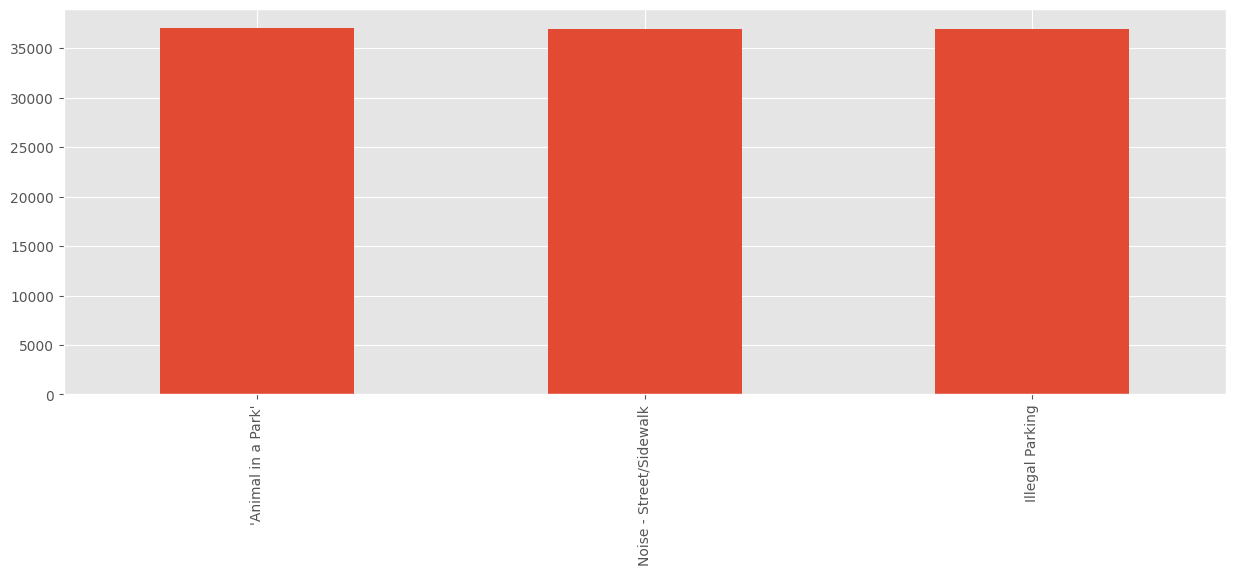

In [31]:
complaint_counts[:10].plot(kind='bar')

## Request real result

Now that we finished our analysis on the mock data, we can request this execution on the real data.

In [32]:
@sy.syft_function(input_policy=sy.ExactMatch(df=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(df):
    complaint_counts = df['Complaint Type'].value_counts()
    return complaint_counts[:10]

Request code execution

In [33]:
req = guest_domain_client.api.services.code.request_code_execution(get_counts)

In [34]:
submitted_code = guest_domain_client.code[0]

In [35]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [36]:
new_project = sy.Project(name="Pandas chapter 2",
                         description="Hi, I would like to plot the histogram of the complaint types.")

In [37]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [38]:
guest_domain_client.submit_project(new_project)

<class 'syft.service.response.SyftSuccess'>: Project Submitted

# Data owner: execute function

In [39]:
domain_client = node.client.login(email="info@openmined.org", password="changethis")

# Get messages

In [40]:
messages = domain_client.api.services.messages.get_all_for_status(sy.MessageStatus.UNDELIVERED)

In [41]:
messages

,type,id,subject,status,created_at,linked_obj
0,syft.service.message.messages.Message,9bb7e5376144416094b9831258a2aa11,Project Approval,MessageStatus.UNDELIVERED,2023-05-16 07:51:21,<<class 'syft.service.project.project.Project'...
1,syft.service.message.messages.Message,73f6dc6be8a24a9f88306ebd84410f0c,Approval Request,MessageStatus.UNDELIVERED,2023-05-16 07:51:19,<<class 'syft.service.request.request.Request'...


In [42]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [43]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [44]:
func

```python
class UserCode:
  id: str = ecab6b129bc740af9cff85c135f7a1c8
  node_uid: str = 40749bbfe1af4a208ca15e0c35be3b09
  user_verify_key: str = 4f45d92eec150ba1625254b0f4ca177228a031381c9ac621b7c6a05024b20acf
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(df=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(df):
    complaint_counts = df['Complaint Type'].value_counts()
    return complaint_counts[:10]
"
  input_policy_type: str = <class 'syft.service.policy.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='pandas-test-domain-1', verify_key=ffec3741dbea0c6c12fe88c656ede492c28f0161752e3f9cd22a1f1bded10f47): {'df': <UID: 6f9d020522af43b58607903a35efa0f6>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.service.policy.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "def user_func_get_counts_4f45d92eec150ba1625254b0f4ca177228a031381c9ac621b7c6a05024b20acf_ced68a4f95bc589adb5d44379eadb950ec506fd867517162b08636312d78c3f6(df):

    def get_counts(df):
        complaint_counts = df['Complaint Type'].value_counts()
        return complaint_counts[:10]
    result = get_counts(df=df)
    return result"
  service_func_name: str = "get_counts"
  unique_func_name: str = "user_func_get_counts_4f45d92eec150ba1625254b0f4ca177228a031381c9ac621b7c6a05024b20acf_ced68a4f95bc589adb5d44379eadb950ec506fd867517162b08636312d78c3f6"
  user_unique_func_name: str = "user_func_get_counts_4f45d92eec150ba1625254b0f4ca177228a031381c9ac621b7c6a05024b20acf"
  code_hash: str = "ced68a4f95bc589adb5d44379eadb950ec506fd867517162b08636312d78c3f6"
  signature: str = (df)
  status: str = {NodeView(node_name='pandas-test-domain-1', verify_key=ffec3741dbea0c6c12fe88c656ede492c28f0161752e3f9cd22a1f1bded10f47): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['df']
  enclave_metadata: str = None

```

In [45]:
get_counts_user_func = func.unsafe_function

In [46]:
real_data = domain_client.datasets[0].assets[0].data

In [47]:
real_result = get_counts_user_func(df=real_data)

In [48]:
real_result[:3]

HEATING                   14200
GENERAL CONSTRUCTION       7471
Street Light Condition     7117
Name: Complaint Type, dtype: int64

In [49]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [50]:
asset = guest_client.datasets[0].assets[0]

In [51]:
guest_client.api.services.code[0].status

{NodeView(node_name='pandas-test-domain-1', verify_key=ffec3741dbea0c6c12fe88c656ede492c28f0161752e3f9cd22a1f1bded10f47): <UserCodeStatus.EXECUTE: 'execute'>}

```python
Pointer
```
<AxesSubplot: >

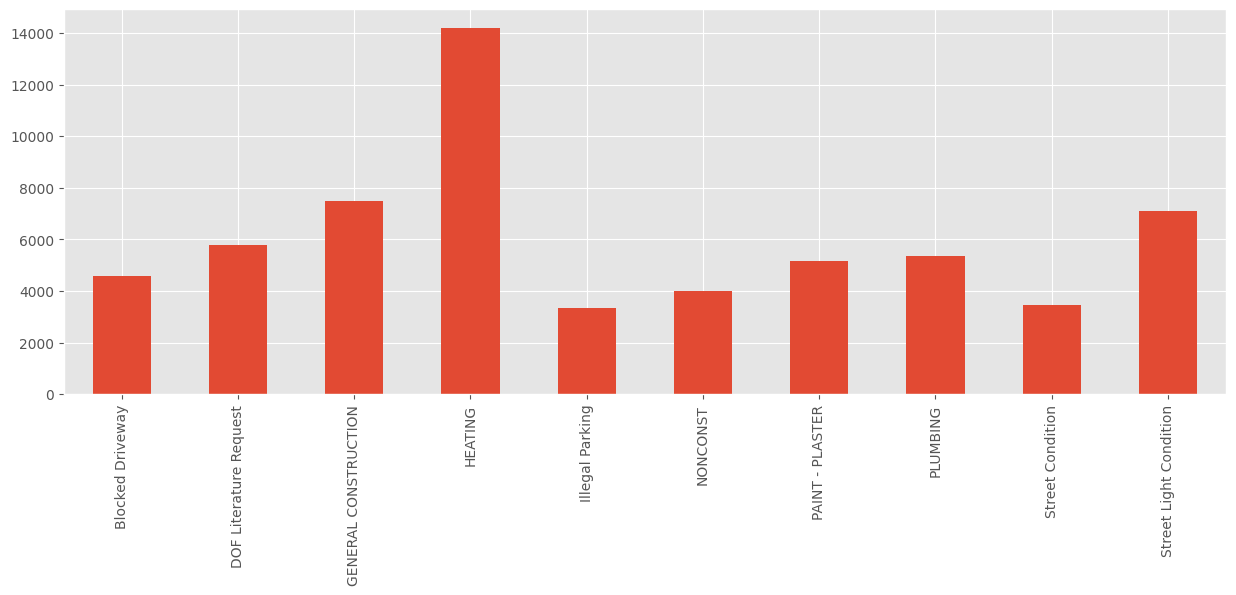

In [52]:
real_result = guest_client.api.services.code.get_counts(df=asset)
real_result.plot(kind="bar")

In [53]:
if node.node_type.value == "python":
    node.land()

Stopping pandas-test-domain-1
